In [1]:
import skimage.io as io
import numpy as np
from src.functions.image_utils import gaussian_focus_stacker, LoG_focus_stacker
from src.functions.utilities import path_leaf
import os
import glob2 as glob
from skimage.transform import resize
from matplotlib import pyplot as plt
import torch

In [21]:
# set path to image files
experiment_date = "20230613"
model_name = "mask_v0_0100"
root = "/media/nick/hdd02/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/morphseq/built_image_data/"
stacked_image_path = os.path.join(root, "keyence_stitched_z", experiment_date, "")
seg_image_path = os.path.join(root, "segmentation", model_name + "_predictions", experiment_date, "")

# get list of image stacks
image_list = sorted(glob.glob(stacked_image_path + "*.tif"))

### Load a sample image stack

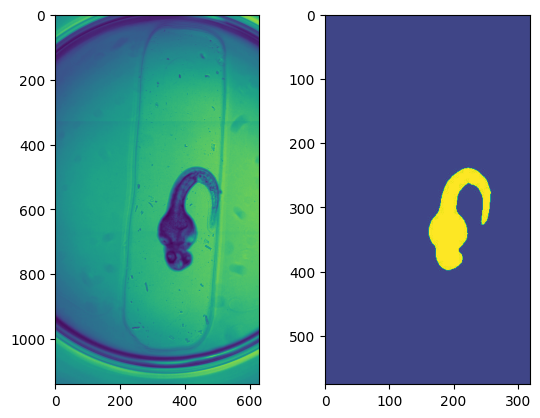

In [22]:
im_ind = 131
im_path = image_list[im_ind]
im_name = path_leaf(im_path)

# load stack
im_stack = io.imread(im_path)

# load mask
mask_path = glob.glob(seg_image_path + im_name[:9] + "*")[0]
im_mask = io.imread(mask_path)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(im_stack[15, :, :])
axarr[1].imshow(im_mask)
plt.show()                    

### Calculate FF using standard method

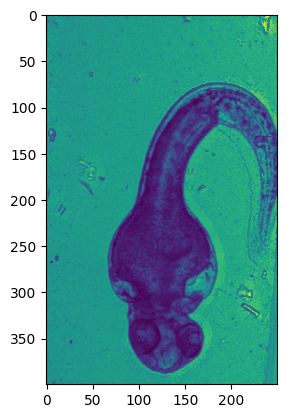

In [26]:
im_FF= LoG_focus_stacker(torch.tensor(im_stack.astype(np.double)), filter_size=3, device="cpu")

plt.imshow(im_FF[400:800, 250:500])
plt.show()

### What if we used a z stack with half the the z resolution?

In [ ]:
im_stack_ds = im_stack[np.arange(0, im_stack.shape[0], 2), :, :]
im_stack_ds2 = im_stack[np.arange(0, im_stack.shape[0], 4), :, :]
im_stack_ds3 = im_stack[np.arange(0, im_stack.shape[0], 6), :, :]
im_FF_ds, _ = LoG_focus_stacker(torch.tensor(im_stack_ds.astype(np.double)), filter_size=3, device="cpu")
im_FF_ds2, _ = LoG_focus_stacker(torch.tensor(im_stack_ds2.astype(np.double)), filter_size=3, device="cpu")
im_FF_ds3, _ = LoG_focus_stacker(torch.tensor(im_stack_ds3.astype(np.double)), filter_size=3, device="cpu")

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(255-im_FF[0:450, 200:500])
axarr[0,1].imshow(255-im_FF_ds[0:450, 200:500])
axarr[1,0].imshow(255-im_FF_ds2[0:450, 200:500])
axarr[1,1].imshow(255-im_FF_ds3[0:450, 200:500])
f.set_figheight(15)
f.set_figwidth(15)
plt.show()      

To my eye, the 2x reduction in z resolution so 80um has almost no impact on quality. Border artifacts a reduction in image sharpness are evident once we go further.

### What if we just take the most in-focus slice?

In [ ]:
# resize the mask
im_mask_rs = resize(im_mask, im_stack.shape[1:], order=0, preserve_range=True)

# turncate the stack
im_stack_trunc = im_stack[6:-6, :, :] # simulate a narrower stack
im_FF, im_laps = LoG_focus_stacker(torch.tensor(im_stack_trunc.astype(np.double)), filter_size=3, device="cpu")
im_FF_g = gaussian_focus_stacker(torch.tensor(im_stack_trunc.astype(np.double)), filter_size=3, device="cpu")

im_laps = np.asarray(im_laps)

focus_vec = np.empty((im_stack_trunc.shape[0]))
for z in range(im_stack_trunc.shape[0]):
    lap_slice = im_laps[z]
    mean_lap = np.mean(lap_slice[im_mask_rs>0])
    focus_vec[z] = mean_lap

best_z = np.argmax(focus_vec)

f, axarr = plt.subplots(1, 3)
axarr[0].imshow(im_FF[100:450, 200:500])
axarr[1].imshow(im_FF_g[100:450, 200:500])
axarr[2].imshow(im_stack_trunc[best_z, 100:450, 200:500])
axarr[0].title.set_text('FF (truncated stack)')
axarr[1].title.set_text('FF (Gauss)')
axarr[2].title.set_text('focus slice')
f.set_figheight(10)
f.set_figwidth(15)
plt.show()    

In [ ]:
focus_vec

In [ ]:
im_laps